# Probabilistic Machine Learning
#### Machine Learning in Science, University of Tübingen, Summer Semester 2022
## Exercise 06

**hand in before 03.06.2022, 12:00 p.m. (noon)**

---

In the lecture you learned about Gaussian process regression, and how it is basically the infinite-dimension limit of classification using generalized linear models. In this programming exercise, you will explore GP classification, using publicly available implementations as well as implementing your own classifier.


## Outline
1) Play around with a toy dataset and the scikit-learn black box GPs to get an intuition on how different kernels behave and ask high-level questions about Gaussian Processes, Kernels, etc. (easy part).

2) Implement a binary GP classification class yourself and apply it to the toy dataset and FashionMNIST dataset (harder part).

# 1) Binary Gaussian process classification using scikit-learn and a toy dataset
Recommended reference: https://scikit-learn.org/stable/modules/gaussian_process.html

Exercise adapted from https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc.html#sphx-glr-download-auto-examples-gaussian-process-plot-gpc-py 
- License disclaimer
```python
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause
```

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, RationalQuadratic, ExpSineSquared

np.random.seed(42)

## Create a toy dataset $p(y, X)$ 
of $N$ samples
$$X \sim U(0, 5)\\ 
    y(X)=\begin{cases}
      0, & \text{if}\ X\leq2.5 \\
      1, & \text{otherwise}
    \end{cases}$$
and split it into training and test splits. (Note: decide on your own how large $N$ and the split ratio is).

In [2]:
# to create a toy dataset
n = 500
train_size = int(n * .8)

X = np.random.uniform(0,5, size=(n,1))
y = np.zeros(n)
y[X[:,0] > 2.5] = 1
X.shape, y.shape

((500, 1), (500,))

In [3]:
# to create a training and testing split
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [4]:
# to verify the split
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (400, 1)
y_train shape:  (400,)
X_test shape:  (100, 1)
y_test shape:  (100,)


## Specify kernels for the Gaussian process classification
- RBF
- Matern
- RationalQuadratic
- ExpSineSquared
- DotProduct

Tipp: check out the documentation in scikit-learn, e.g. for RBF
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html

In [5]:
# specify the kernels
RBF_kernel = 1.0 * RBF(1.0)
Matern_kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
RationalQuadratic_kernel = 1 * RationalQuadratic(length_scale=1.0, alpha=1.5)
ExpSineSquared_kernel = 1 * ExpSineSquared(length_scale=1, periodicity=1)
DotProduct_kernel = DotProduct()

## Instantiate Gaussian process classifier (GPC) objects

Choose a kernel and create the Gaussian process classifier instances.
To compare the initial kernel vs. the optimized kernel, create two instances: (1) `gp_fix` with `optimizer=None` and (2) `gp_opt` without specifying `optimizer`, leaving it at its default value (maximum log-marginal likelihood estimation). Call the `.fit(X, y)` method on both to fit the training data. 

In [6]:
# Specify Gaussian Processes with fixed and optimized hyperparameters
gp_fix = GaussianProcessClassifier(optimizer=None, kernel=RBF_kernel)
gp_fix.fit(X_train,y_train)

gp_opt = GaussianProcessClassifier(kernel=RBF_kernel)
gp_opt.fit(X_train,y_train)

/Users/leander/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/leander/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [7]:
# to verify the kernels differ
gp_fix.kernel_, gp_opt.kernel_

(1**2 * RBF(length_scale=1), 316**2 * RBF(length_scale=1.51))

## Print the log marginal likelihood $\text{log} p(\theta)$ for the kernel parameter to compare the initial and the optimized kernel parameter log probabilities

In [8]:
print("Log Marginal Likelihood (initial): %.3f"
      % gp_fix.log_marginal_likelihood(gp_fix.kernel_.theta))
print("Log Marginal Likelihood (optimized): %.3f"
      % gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta))

Log Marginal Likelihood (initial): -53.115
Log Marginal Likelihood (optimized): -6.603


## Print the accuracy (using `accuracy_score`) between prediction and ground truth class to compare the initialized and the optimized GPC classification performance

In [9]:
print("Accuracy: %.3f (initial) %.3f (optimized)"
      % (accuracy_score(y_test, gp_fix.predict(X_test)),
         accuracy_score(y_test, gp_opt.predict(X_test))))

Accuracy: 0.980 (initial) 1.000 (optimized)


## Print the log loss (using `log_loss`) between prediction and ground truth class to compare how the maximum log-marginal likelihood estimates compare to the arbitrary kernel parameters 

In [10]:
print("Log-loss: %.3f (initial) %.3f (optimized)"
      % (log_loss(y_test, gp_fix.predict_proba(X_test)),
         log_loss(y_test, gp_opt.predict_proba(X_test))))

Log-loss: 0.086 (initial) 0.198 (optimized)


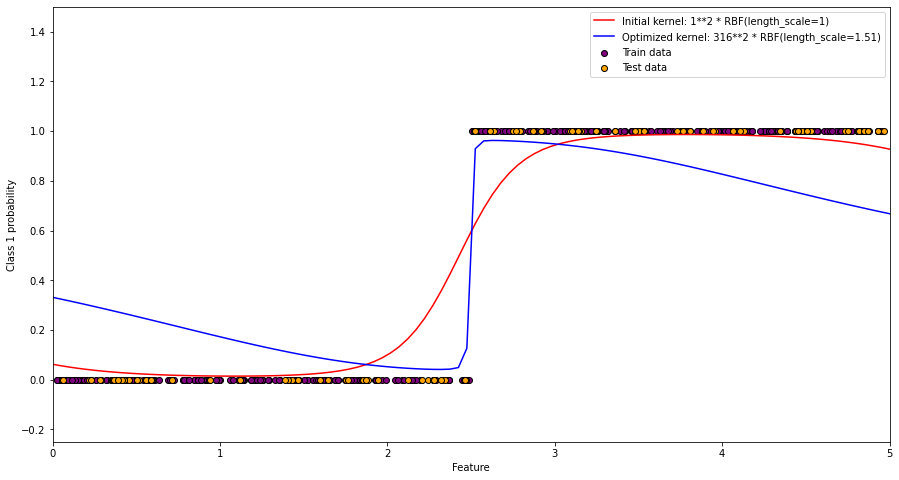

In [11]:
# Plot posteriors
plt.figure(figsize=(15,8))
plt.scatter(X_train[:, 0], y_train, c='purple', label="Train data",
            edgecolors=(0, 0, 0))
plt.scatter(X_test[:, 0], y_test, c='orange', label="Test data",
            edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)
plt.plot(X_, gp_fix.predict_proba(X_[:, np.newaxis])[:, 1], 'r',
         label="Initial kernel: %s" % gp_fix.kernel_)
plt.plot(X_, gp_opt.predict_proba(X_[:, np.newaxis])[:, 1], 'b',
         label="Optimized kernel: %s" % gp_opt.kernel_)
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")
plt.show()

<ipython-input-12-1181c4605a36>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Theta0, Theta1, LML)


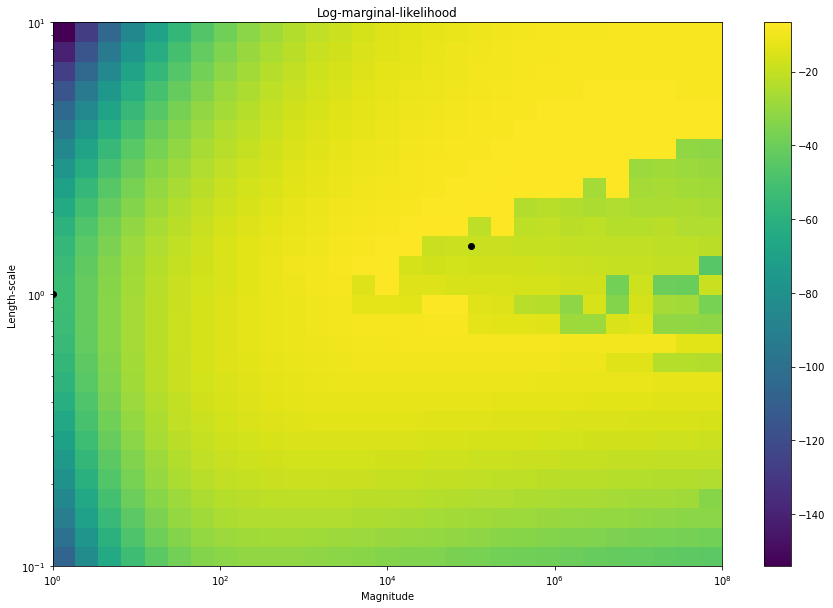

In [12]:
# Plot LML landscape
plt.figure(figsize=(15,10))
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp_opt.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T
plt.plot(np.exp(gp_fix.kernel_.theta)[0], np.exp(gp_fix.kernel_.theta)[1],
         'ko', zorder=10)
plt.plot(np.exp(gp_opt.kernel_.theta)[0], np.exp(gp_opt.kernel_.theta)[1],
         'ko', zorder=10)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")

plt.show()

## Questions:
1. What do the blue and the red line in the posterior plot represent?
2. What does the log-marginal-likelihood describe and what is it used for?
3. Using an initial RBF kernel `1**2 * RBF(length_scale=1)`, can you use the plot of the class 1 probability to reason about why the log loss with the initial RBF kernel is lower than with the optimized RBF kernel?
4. Check out all 5 different kernels. Which one is the best fit? Is any Kernel strictly better than another?
5. Implement a different function and test it with all 5 Kernels. Is every Kernel able to fit the problem? The function can be simple, e.g. 1 if x < 1 or x > 4, 0 else.

Note: text of single sentences to answer the questions that don't require code at this point are sufficient.

## Answers:
1. Both show the output probability (for class 1) of the corresponding estimator, over the given sample X.  The blue line is using the optimized Kernel, which results in a much sharper deision boundary
2. 
3. While in the middle, the optimized kernel outputs probabilities closer ot 0 and 1, towards X=0 and X=5, it is the other way around, s.t. the optimized kernel produces probabilities close to .5 overall, resulting in a higher loss inspite of the perfect acuracy.
4. Most Kernels produce a really good accuracy. In terms of log loss the optimized DotProduct Kernel, followed by the unoptimized MaternKernel perform the best. The unoptimized ExpSineSquared Kernel is not usable for this problem

# 2) Implementing a binary Gaussian process classification object

Instructions:
- complete the methods `fit`, `predict_all` of the class `GPClassifier`. This is supposed to give some structure to the programming to focus on the hard parts. Feel free to implement your own way from scratch. We suggest you document *why* you implement it the way you do.

```python
from scipy.stats import norm
from scipy.integrate import quad
from scipy.special import expit as sigmoid
from scipy.spatial.distance import cdist

# based on the implementation given in the book by Rasmussen and Williams
class GPClassifier:
    
    def __init__(self, X, y, kernel):
        self.X = X
        self.y = y
        self.kernel = kernel
        self.K = self.kernel(self.X, self.X)
        assert len(self.X) == len(self.y)
        self.size = len(self.X)
        
        self.f = None
        self.W = None
        self.L = None 
            
    def fit(self):
        """Single class, mode-finding algorithm for binary GPC.
        
        Returns:
             float: Log-marginal likelihood after convergence, 
                 here |obj - obj_old| < 1e-5.
                 
        Note:
            Requires:
                self.K        
            Updates:
                self.W
                self.L
                self.f
        
        Reference: Algorithm 3.1, Rasmussen and Williams
        """
        ...
                
    
    def predict_all(self, X_pred):
        """Predictions for binary GPC.
        
        Returns:
            array: predictive class probability for class 1.
            array: class labels y_pred.
            
        Note:
            Requires:
                self.X
                self.y
                self.L
                self.W
                self.kernel
                self.f          
        
        Reference: Algorithm 3.2, Rasmussen and Williams
        """
        ...
```

- only consider binary classification
- use the cholesky decomposition to solve the linear system because that is numerically stable
- use the kernel parameters suggested in the toy example instead of implementing an optimizer

- Hints: 
    1. Use the knowledge from the lecture on GPs and Gaussian_Process_Regression_2022.ipynb. You can base your implementation on the classification algorithm (3.1) from Rasmussen and Williams in http://www.gaussianprocess.org/gpml/chapters/RW3.pdf.
    2. Implement the likelihood according to using [0,1] labels.
    3. You can compute a definite integral using `scipy.integrate.quad`.

In [175]:
# implement your GPClassifier here
from scipy.stats import norm
from scipy.integrate import quad
from scipy.special import expit as sigmoid
from scipy.spatial.distance import cdist
from numpy.linalg import cholesky, solve


# based on the implementation given in the book by Rasmussen and Williams
class GPClassifier:
    
    def __init__(self, X, y, kernel):
        self.X = X
        self.y = y
        self.kernel = kernel
        self.K = self.kernel(self.X, self.X)
        assert len(self.X) == len(self.y)
        self.size = len(self.X)
        
        self.f = None
        self.W = None
        self.L = None 
        
    def fit(self):
        """Single class, mode-finding algorithm for binary GPC.
        
        Returns:
             float: Log-marginal likelihood after convergence, 
                 here |obj - obj_old| < 1e-5.
                 
        Note:
            Requires:
                self.K        
            Updates:
                self.W
                self.L
                self.f
        
        Reference: Algorithm 3.1, Rasmussen and Williams
        """
        f = f = np.zeros_like(self.y, dtype=np.float64)
        log_marginal_likelihood = -np.inf
        while True: 
            # Line 4
            pi = sigmoid(f)
            W = pi * (1 - pi)
            # Line 5
            W_sr = np.sqrt(W)
            W_sr_K = W_sr[:, np.newaxis] * self.K
            B = np.eye(W.shape[0]) + W_sr_K * W_sr
            L = cholesky(B)
            # Line 6
            b = W * f + (self.y - pi)
            # Line 7
            a = b - W_sr * cho_solve((L, True), W_sr_K.dot(b))
            # Line 8
            f = self.K.dot(a)
            
            # Line 10: Compute log marginal likelihood in loop and use as
            #          convergence criterion
            lml = (
                -0.5 * a.T.dot(f)
                - np.log1p(np.exp(-(self.y * 2 - 1) * f)).sum()
                - np.log(np.diag(L)).sum()
            )
            # Check if we have converged (log marginal likelihood does
            # not decrease)
            # XXX: more complex convergence criterion
            if lml - log_marginal_likelihood < 1e-5:
                break
            log_marginal_likelihood = lml
            
        self.f = f
        self.W = W 
        self.L = L
        return log_marginal_likelihood
                
    def fit_(self):
        """Single class, mode-finding algorithm for binary GPC.
        
        Returns:
             float: Log-marginal likelihood after convergence, 
                 here |obj - obj_old| < 1e-5.
                 
        Note:
            Requires:
                self.K        
            Updates:
                self.W
                self.L
                self.f
        
        Reference: Algorithm 3.1, Rasmussen and Williams
        """
        f = np.zeros(size)
        log_marginal_likelihood = -np.inf
        while True: 
            # Line 4
            pi = sigmoid(f)
            W = np.zeros_like(self.K)
            
            np.fill_diagonal(W, (pi * (1-pi)))
            W_sqrt = np.sqrt(W)
            
            # Line 5
            B = np.identity(W.shape[0]) + W_sqrt @ self.K @ W_sqrt

            L = np.linalg.cholesky(B)
            
            # Line 6
            b = W @ f + (self.y - pi)

            # Line 7
            a = b - W_sqrt @ solve(L.T, solve(L, W_sqrt @ self.K @ b))
            
            # Line 8
            f = self.K @ a
            
            # Line 10:
            lml = (-0.5 * a.T @ f) - np.log(1 + np.exp(((self.y*2)-1) @ f)) - np.log(L.diagonal()).sum()
            
            # Check if we have converged (log marginal likelihood does
            # not decrease)
            if np.abs(lml - log_marginal_likelihood) < 1e-5:
                break
            log_marginal_likelihood = lml
            
        self.f = f
        self.W = W 
        self.L = L
        return log_marginal_likelihood
    
    def predict_all(self, X_pred):
        """Predictions for binary GPC.
        
        Returns:
            array: predictive class probability for class 1.
            array: class labels y_pred.
            
        Note:
            Requires:
                self.X
                self.y
                self.L
                self.W
                self.kernel
                self.f          
        
        Reference: Algorithm 3.2, Rasmussen and Williams
        """
        K_star = self.kernel(self.X, X_pred)  # K_star =k(x_star)
        f_star = K_star.T.dot(self.y - sigmoid(self.f))  # Line 4
        v = solve(self.L, np.sqrt(self.W)[:, np.newaxis] * K_star)  # Line 5
        # Line 6 (compute np.diag(v.T.dot(v)) via einsum)
        var_f_star = self.kernel.diag(X_pred) - np.einsum("ij,ij->j", v, v)
        
        #print(f_star.shape)
        #print(var_f_star.shape)
        
        quad(lambda z: sigmoid(z)*norm.pdf(z, loc=f_star, scale=var_f_star), -np.inf, np.inf)
        return (_, y_pred)

## Use your own GPC implementation to classify the toy data from exercise 1)
Instructions:
- implement the rbf kernel (and e.g. linear) to be used with `GPClassifier`.
    E.g.:
    ``` python
    # kernels:
    def rbf(x1,x2, sigma, ell):
        ...
    def linear(x_1, x_2, sigma):
        ...
        
    # set the kernel parameters from the toy example
    rbf_kernel = lambda x1, x2: rbf(x1, x2, 91.7, 1.12)
    linear_kernel = lambda x1, x2: linear(x1, x2, ?)
    ```
- compare your results to the scikit-learn off-the-shelf GP. Hint: they should be similar ;)

In [176]:
# to create a toy dataset
n = 100
train_size = 50
X = np.random.uniform(0, 5, n)
y = (X > 2.5).astype(int)  # using bool to int casting
# to create a training and testing split
X_train = X[0:train_size].reshape(-1,1)
y_train = y[0:train_size]
X_test = X[train_size:n].reshape(-1,1)
y_test = y[train_size:n]
# to verify the split
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (50, 1)
y_train shape:  (50,)
X_test shape:  (50, 1)
y_test shape:  (50,)


In [ ]:
# implement your kernels here and classify the toy data
RBF_kernel_opt= 316**2 * RBF(length_scale=1.51)
gpc = GPClassifier(X_train, y_train, RBF_kernel_opt)
gpc.fit()

<ipython-input-175-ef12f1c33b29>:66: RuntimeWarning: overflow encountered in exp
  lml = (-0.5 * a.T @ f) - np.log(1 + np.exp(((self.y*2)-1) @ f)) - np.log(L.diagonal()).sum()
<ipython-input-175-ef12f1c33b29>:70: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(lml - log_marginal_likelihood) < 1e-5:


## Use your own GPC implementation to separate images of Tshirts from images of Trousers using Fashion MNIST
Instructions:
- we use class 0 for t-shirts/tops and class 1 for trousers as the two classes for the binary classification.
- the nasty data wrangling stuff has already been done for you by Pytorch and us.
- decide on a considerate number of samples to train the GPC.
- how accurate can you separate images of Tshirts from images of Trousers using your own `GPClassifier`?

In [ ]:
import torch, torchvision
import torchvision.transforms as transforms
torch.manual_seed(42)

In [ ]:
# data wrangling: get the first two classes for FMNIST
FMNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


FMNIST_train = torchvision.datasets.FashionMNIST(
        '~/data/fmnist',
        train=True,
        download=True,
        transform=FMNIST_transform)


FMNIST_test = torchvision.datasets.FashionMNIST(
        '~/data/fmnist',
        train=False,
        download=True,
        transform=FMNIST_transform)

def get_subset_FMNIST(classes=[0,1], dataset=FMNIST_train):
    
    dataset.targets = dataset.targets.clone().detach()
    idx = torch.zeros(dataset.targets.size()).byte()
    for c in classes:
        idx += (dataset.targets==c).byte()
    dataset.targets= dataset.targets[idx]
    dataset.data = dataset.data[idx.numpy().astype(np.bool)]
    
    #remap all classes to list of ints starting at 1
    map_dict = dict()
    for i, c in enumerate(classes):
        map_dict[c] = i
    
    for i, t in enumerate(dataset.targets):
        dataset.targets[i] = map_dict[t.item()]
    
    return(dataset.data, dataset.targets)

classes = [0,1]
FMNIST_train.data, FMNIST_train.targets = get_subset_FMNIST(classes=classes, dataset=FMNIST_train)
FMNIST_test.data, FMNIST_test.targets = get_subset_FMNIST(classes=classes, dataset=FMNIST_test)
print(len(FMNIST_train.targets))
print(FMNIST_train.targets[:10])
print(len(FMNIST_test.targets))
print(FMNIST_test.targets[:10])

In [ ]:
# have a look at the images corresponding to FMNIST_train.targets[:10] 
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = FMNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))

In [ ]:
# further data wrangling

n_train_samples = ...

X_train = FMNIST_train.data[:n_train_samples].view(-1, 28*28)
y_train = FMNIST_train.targets[:n_train_samples].view(-1)

X_test = FMNIST_test.data.view(-1, 28*28)
y_test = FMNIST_test.targets.view(-1)

#normalize the data between [-1,1]
X_train = (X_train.float() - 128) / 128
X_test = (X_test.float() - 128) / 128

X_train, X_test = X_train.numpy(), X_test.numpy()
y_train, y_test = y_train.numpy(), y_test.numpy()

In [ ]:
# classify the data here and report your accuracy
...